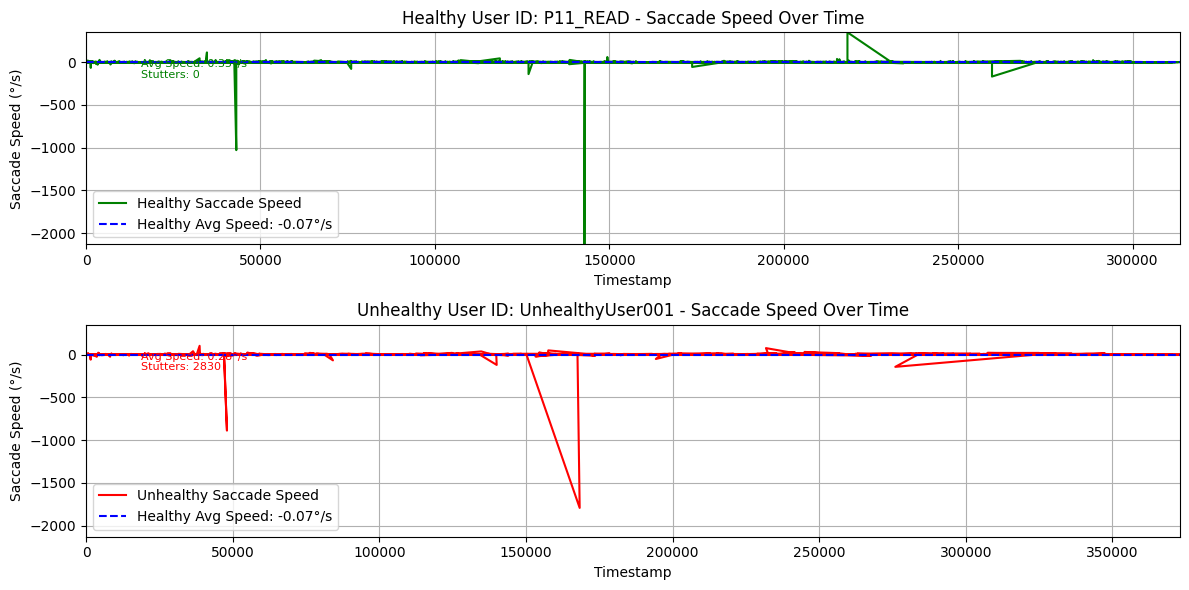

Concussion Likelihood: 0%


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import norm
from imblearn.over_sampling import SMOTE

# Function to load data
def load_data(input_dir):
    data_frames = {}
    for root, _, files in os.walk(input_dir):
        for file in files:
            if file.endswith(".csv") and "_READ" in file:
                file_path = os.path.join(root, file)
                person_id = file.replace(".csv", "")
                data_frames[person_id] = pd.read_csv(file_path)
    return data_frames

# Function to calculate saccade speed
def calculate_saccade_speed(data):
    data['x'] = pd.to_numeric(data['x'], errors='coerce')
    data['y'] = pd.to_numeric(data['y'], errors='coerce')
    data['timestamp'] = pd.to_numeric(data['timestamp'], errors='coerce')

    # Drop any rows that couldn't be converted properly
    data = data.dropna(subset=['x', 'y', 'timestamp'])

    # Calculate speed as Euclidean distance between consecutive points divided by time difference
    data['saccade_speed'] = np.sqrt((data['x'].diff() ** 2) + (data['y'].diff() ** 2)) / data['timestamp'].diff()
    data['saccade_speed'] = data['saccade_speed'].fillna(0)
    return data

# Function to expand healthy dataset while preserving natural behavior (no stutters added here)
def expand_healthy_data(healthy_data, expansion_factor=3, noise_level=0.05):
    expanded_data = [healthy_data]  # Start with original data
    for _ in range(expansion_factor):
        synthetic_data = healthy_data.copy()
        # Apply minimal variation to x, y positions
        synthetic_data['x'] += np.random.normal(0, noise_level * healthy_data['x'].std(), size=len(healthy_data))
        synthetic_data['y'] += np.random.normal(0, noise_level * healthy_data['y'].std(), size=len(healthy_data))
        # Apply slight timestamp jitter (simulate natural reaction time variation)
        synthetic_data['timestamp'] *= 1 + np.random.uniform(-0.05, 0.05, size=len(healthy_data))
        expanded_data.append(synthetic_data)
    return pd.concat(expanded_data, ignore_index=True)

def simulate_unhealthy_data(healthy_data):
    unhealthy_data = healthy_data.copy()
    
    # Randomize the slowdown factor (base and variation) each time
    base_slowdown_factor = np.random.uniform(0.85, 0.95)  # Reduced the range to not deviate as much
    variation_factor = np.random.uniform(0.01, 0.05)  # Smaller variation for more subtle change
    
    # Apply the random slowdown factor to the saccade speeds
    unhealthy_data['saccade_speed'] *= np.random.uniform(
        base_slowdown_factor - variation_factor, 
        base_slowdown_factor + variation_factor, 
        size=len(healthy_data)
    )
    
    # Introduce random stuttering: apply random significant reduction to saccade speed
    stutter_indices = np.random.choice(unhealthy_data.index, size=int(np.random.uniform(0.05, 0.10) * len(healthy_data)), replace=False) 
    unhealthy_data.loc[stutter_indices, 'saccade_speed'] *= np.random.uniform(0.2, 0.5, size=len(stutter_indices))  # Moderate slowdown at stutter points
    
    # Introduce rereading: Randomly apply small variations to x and y positions
    reread_indices = np.random.choice(unhealthy_data.index, size=int(np.random.uniform(0.02, 0.05) * len(healthy_data)), replace=False)  
    unhealthy_data.loc[reread_indices, 'x'] *= np.random.uniform(0.95, 1.05, size=len(reread_indices))  # Smaller variation to x positions
    unhealthy_data.loc[reread_indices, 'y'] *= np.random.uniform(0.95, 1.05, size=len(reread_indices))  # Smaller variation to y positions
    
    # Introduce hesitation: apply random timestamp variation
    unhealthy_data['timestamp'] *= np.random.uniform(1.05, 1.2, size=len(healthy_data))  # More subtle hesitation
    
    # Randomly introduce an additional slowdown factor to some saccades
    extra_slowdown_factor = np.random.uniform(0.95, 0.98)  # Smaller additional slowdown factor
    extra_slowdown_indices = np.random.choice(unhealthy_data.index, size=int(np.random.uniform(0.03, 0.08) * len(healthy_data)), replace=False)
    unhealthy_data.loc[extra_slowdown_indices, 'saccade_speed'] *= extra_slowdown_factor
    
    # Apply additional random jitter to x and y positions for more randomness
    jitter_factor = np.random.uniform(0.98, 1.02)  # Reduced jitter factor
    unhealthy_data['x'] *= jitter_factor
    unhealthy_data['y'] *= jitter_factor
    
    return unhealthy_data, len(stutter_indices)


# Function to calculate concussion likelihood based on speed deviation and stutter count
def calculate_concussion_likelihood(healthy_avg_speed, patient_avg_speed, stutter_count):
    # Calculate the absolute deviation between patient and healthy average speeds
    deviation = abs(patient_avg_speed - healthy_avg_speed)
    
    # Normalize deviation with respect to healthy speed, but apply a lower scaling factor
    normalized_deviation = deviation / healthy_avg_speed
    
    # Scale the likelihood more gradually
    likelihood = normalized_deviation * 50  # Reduce the impact of deviation (max 50%)
    
    # Add the stutter count contribution (each stutter adds a smaller effect)
    likelihood += stutter_count * .01  # Each stutter adds a smaller amount to likelihood
    
    # Limit the likelihood to reasonable bounds (e.g., between 0 and 100)
    likelihood = min(100, max(0, likelihood))  # Avoiding excessive values
    
    return likelihood




# Visualization function for saccade speed over time
def visualize_saccade_over_time(healthy_data, unhealthy_data, healthy_avg_speed, healthy_user_id, unhealthy_user_id, stutter_count):
    plt.figure(figsize=(12, 6))
    
    # Plot for Healthy User (should have no stutters)
    plt.subplot(2, 1, 1)
    plt.plot(healthy_data['timestamp'], healthy_data['saccade_speed'], label='Healthy Saccade Speed', color='green')
    plt.axhline(y=healthy_avg_speed, color='blue', linestyle='--', 
                label=f'Healthy Avg Speed: {healthy_avg_speed:.2f}°/s')
    plt.title(f"Healthy User ID: {healthy_user_id} - Saccade Speed Over Time")
    plt.xlabel("Timestamp")
    plt.ylabel("Saccade Speed (°/s)")
    plt.legend()
    plt.grid(True)
    plt.xlim([healthy_data['timestamp'].min(), healthy_data['timestamp'].max()])
    plt.ylim([min(healthy_data['saccade_speed'].min(), unhealthy_data['saccade_speed'].min()), 
              max(healthy_data['saccade_speed'].max(), unhealthy_data['saccade_speed'].max())])
    # Annotate with average speed and note that healthy data has no stutters
    plt.annotate(f"Avg Speed: {np.mean(healthy_data['saccade_speed']):.2f}°/s", 
                 xy=(0.05, 0.85), xycoords='axes fraction', ha='left', va='center', fontsize=8, color='green')
    plt.annotate("Stutters: 0", 
                 xy=(0.05, 0.8), xycoords='axes fraction', ha='left', va='center', fontsize=8, color='green')
    
    # Plot for Unhealthy User (with stutters)
    plt.subplot(2, 1, 2)
    plt.plot(unhealthy_data['timestamp'], unhealthy_data['saccade_speed'], label='Unhealthy Saccade Speed', color='red')
    plt.axhline(y=healthy_avg_speed, color='blue', linestyle='--', 
                label=f'Healthy Avg Speed: {healthy_avg_speed:.2f}°/s')
    plt.title(f"Unhealthy User ID: {unhealthy_user_id} - Saccade Speed Over Time")
    plt.xlabel("Timestamp")
    plt.ylabel("Saccade Speed (°/s)")
    plt.legend()
    plt.grid(True)
    plt.xlim([unhealthy_data['timestamp'].min(), unhealthy_data['timestamp'].max()])
    plt.ylim([min(healthy_data['saccade_speed'].min(), unhealthy_data['saccade_speed'].min()), 
              max(healthy_data['saccade_speed'].max(), unhealthy_data['saccade_speed'].max())])
    # Annotate with average speed and stutter count for the unhealthy dataset
    plt.annotate(f"Avg Speed: {np.mean(unhealthy_data['saccade_speed']):.2f}°/s", 
                 xy=(0.05, 0.85), xycoords='axes fraction', ha='left', va='center', fontsize=8, color='red')
    plt.annotate(f"Stutters: {stutter_count}", 
                 xy=(0.05, 0.8), xycoords='axes fraction', ha='left', va='center', fontsize=8, color='red')
    
    plt.tight_layout()
    plt.show()

# Main script
if __name__ == "__main__":
    input_dir = "/kaggle/input/eye-movement-data-set-for-desktop-activities"
    
    # Load data from CSV files
    data_frames = load_data(input_dir)
    
    # Expand healthy datasets (this will generate multiple variants, all without stutters)
    for person_id in data_frames.keys():
        data_frames[person_id] = expand_healthy_data(data_frames[person_id])
    
    # Calculate healthy saccade speeds for all patients to form a baseline
    healthy_speeds = []
    for person_id, data in data_frames.items():
        processed_data = calculate_saccade_speed(data)
        healthy_speeds.extend(processed_data['saccade_speed'].tolist())
    
    healthy_avg_speed = np.mean(healthy_speeds)
    healthy_speed_std = np.std(healthy_speeds)
    
    # Randomly select one healthy user from the dataset (this data is clean – no stutters)
    random_healthy_person_id = random.choice(list(data_frames.keys()))
    healthy_data = data_frames[random_healthy_person_id]
    healthy_data_processed = calculate_saccade_speed(healthy_data)
    
    # Simulate an unhealthy user by adding stutters and other effects to the healthy data
    unhealthy_data, stutter_count = simulate_unhealthy_data(healthy_data_processed)
    
    # Visualize the healthy (clean) and simulated unhealthy data
    visualize_saccade_over_time(healthy_data_processed, unhealthy_data, healthy_avg_speed, 
                                random_healthy_person_id, "UnhealthyUser001", stutter_count)
    
    # Calculate concussion likelihood based on the deviation from healthy speeds and stutter count
    patient_avg_speed = np.mean(unhealthy_data['saccade_speed'])
    concussion_likelihood = calculate_concussion_likelihood(healthy_avg_speed, patient_avg_speed, stutter_count)
    print(f"Concussion Likelihood: {concussion_likelihood}%")
    
    # Symptom CLI function to further adjust likelihood based on manual input
    #calculate_concussion_likelihood(concussion_likelihood)


Accuracy: 1.00

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



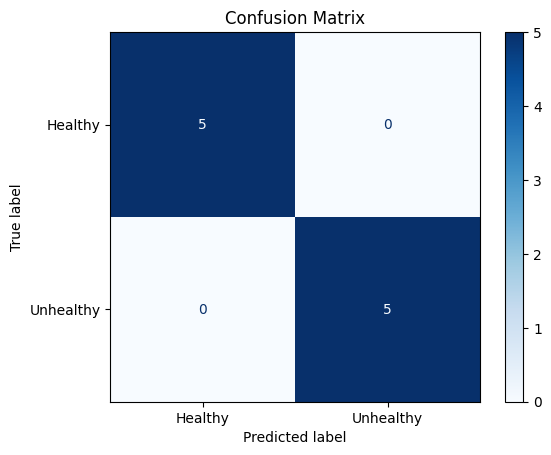

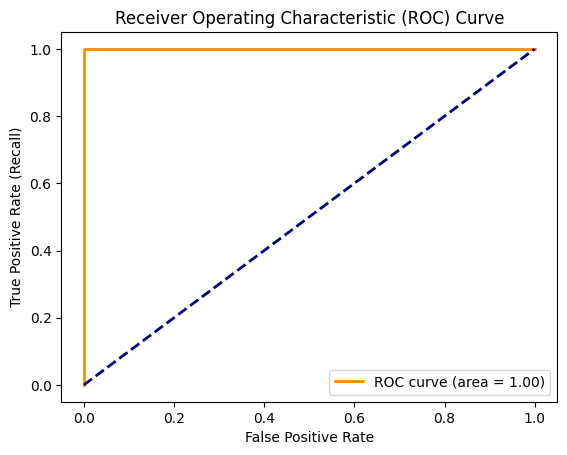

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Function to load data (unchanged)
def load_data(input_dir):
    data_frames = {}
    for root, _, files in os.walk(input_dir):
        for file in files:
            if file.endswith(".csv") and "_READ" in file:
                file_path = os.path.join(root, file)
                person_id = file.replace(".csv", "")
                data_frames[person_id] = pd.read_csv(file_path)
    return data_frames

# Function to calculate saccade speed (unchanged)
def calculate_saccade_speed(data):
    data['x'] = pd.to_numeric(data['x'], errors='coerce')
    data['y'] = pd.to_numeric(data['y'], errors='coerce')
    data['timestamp'] = pd.to_numeric(data['timestamp'], errors='coerce')
    data = data.dropna(subset=['x', 'y', 'timestamp'])
    data['saccade_speed'] = np.sqrt((data['x'].diff() ** 2) + (data['y'].diff() ** 2)) / data['timestamp'].diff()
    data['saccade_speed'] = data['saccade_speed'].fillna(0)
    return data

# Function to expand healthy data (unchanged)
def expand_healthy_data(healthy_data, expansion_factor=3, noise_level=0.05):
    expanded_data = [healthy_data]
    for _ in range(expansion_factor):
        synthetic_data = healthy_data.copy()
        synthetic_data['x'] += np.random.normal(0, noise_level * healthy_data['x'].std(), size=len(healthy_data))
        synthetic_data['y'] += np.random.normal(0, noise_level * healthy_data['y'].std(), size=len(healthy_data))
        synthetic_data['timestamp'] *= 1 + np.random.uniform(-0.05, 0.05, size=len(healthy_data))
        expanded_data.append(synthetic_data)
    return pd.concat(expanded_data, ignore_index=True)

# Simulate unhealthy data (unchanged)
def simulate_unhealthy_data(healthy_data):
    unhealthy_data = healthy_data.copy()
    base_slowdown_factor = np.random.uniform(0.85, 0.95)
    variation_factor = np.random.uniform(0.01, 0.05)
    unhealthy_data['saccade_speed'] *= np.random.uniform(base_slowdown_factor - variation_factor, base_slowdown_factor + variation_factor, size=len(healthy_data))
    stutter_indices = np.random.choice(unhealthy_data.index, size=int(np.random.uniform(0.05, 0.10) * len(healthy_data)), replace=False) 
    unhealthy_data.loc[stutter_indices, 'saccade_speed'] *= np.random.uniform(0.2, 0.5, size=len(stutter_indices))
    reread_indices = np.random.choice(unhealthy_data.index, size=int(np.random.uniform(0.02, 0.05) * len(healthy_data)), replace=False)
    unhealthy_data.loc[reread_indices, 'x'] *= np.random.uniform(0.95, 1.05, size=len(reread_indices))
    unhealthy_data.loc[reread_indices, 'y'] *= np.random.uniform(0.95, 1.05, size=len(reread_indices))
    unhealthy_data['timestamp'] *= np.random.uniform(1.05, 1.2, size=len(healthy_data))
    return unhealthy_data, len(stutter_indices)

# Prepare data for machine learning (new function)
def prepare_ml_data(data_frames):
    features = []
    labels = []
    
    # Collect data for healthy and unhealthy
    for person_id, data in data_frames.items():
        processed_data = calculate_saccade_speed(data)
        avg_speed = np.mean(processed_data['saccade_speed'])
        stutter_count = 0  # Healthy data has no stutters
        features.append([avg_speed, stutter_count])
        labels.append(0)  # Label 0 for healthy
        
        # Simulate unhealthy data
        unhealthy_data, stutter_count = simulate_unhealthy_data(processed_data)
        avg_speed = np.mean(unhealthy_data['saccade_speed'])
        features.append([avg_speed, stutter_count])
        labels.append(1)  # Label 1 for unhealthy
    
    return np.array(features), np.array(labels)

# Main function for training and prediction (new)
def train_and_predict():
    input_dir = "/kaggle/input/eye-movement-data-set-for-desktop-activities"
    
    # Load data from CSV files
    data_frames = load_data(input_dir)
    
    # Expand healthy datasets
    for person_id in data_frames.keys():
        data_frames[person_id] = expand_healthy_data(data_frames[person_id])
    
    # Prepare features and labels for ML
    features, labels = prepare_ml_data(data_frames)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    # Initialize and train Random Forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rf_model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: {:.2f}".format(accuracy))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Visualize the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Unhealthy"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Run the machine learning model training and evaluation
train_and_predict()
